This is an idea to use co-aggregation data to generate a Co-aggregation Distribution. We could use this to simulate contact tracing network datasets, which we can then use with the methods set out by Lloyd-Smith et al (2005).

---

Co-aggregation is the phenomenon where larval and nymphal ticks co-feed on the same relatively small number of vertebrate hosts; the 80:20 rule is frequently found to be a good description of tick aggregation.

Co-aggregation can be thought of as a bipartite graph. The work by Johnstone-Robertson and others showed that if we treat each vertebrate host as a node, then the degree $ k_{in} $ is the number of nymphs and $ k_{out} $ is the number of larvae for any one node (vertebrate). That research is the inspiration for the following idea.

A single vertebrate host might have this co-aggregation network, with $k_{in}$ nymphs and $k_{out}$ larvae:

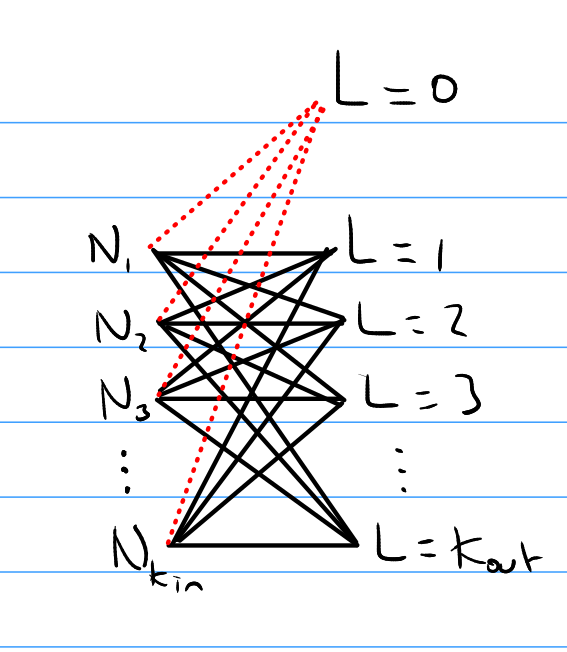

We can ask: what is the expected number of larvae that an individual nymph will co-aggregate with? We include the cases where a nymph doesn't co-aggregate with any larvae, which is known as a "wasted bite". We do not consider the situation where larvae aggregate without nymphs.

Then for each vertebrate, or node in the network, and for each nymph on that vertebrate, record the $ k_{out} $ as the number of larvae that a single nymph co-aggregates with. Let these values form a "Co-aggregation Distribution". We could either:

- Fit an appropriate distribution to the data and draw variables from it randomly.
- Take the Co-aggregation Distribution as-is and draw from it uniform-randomly.

For simplicity, for now, use the second option.

---

This is a process for generating an offspring distribution.

Definitions:
- Let $ c $ be the contact rate, or probability that co-aggregation occurs close enough for a nymph to transmit the pathogen to a larva.
- Let $ v $ be the probability of successfully transmitting the pathogen from nymph to larvae. This accounts for individual transmission competence.
- Let $ \sigma $ be the probability that an infected larvae survives to become a nymph.
- Let $ \alpha = \sigma v c $ be the overall probability that a larvae becomes an infectious nymph. In other words, a larvae that coaggregates with a nymph becomes an offspring.

Then we can simulate disease outbreaks with the below stochastic process:

- Start with one infected nymph and uniform randomly draw $ L $ from the Co-aggregation Distribution. $ L $ is a random variable of the number of larvae that a single nymph co-aggregates with. This would be $ k_{out} $, in the notation created by Johnstone-Robertson and others in 2020.
- If $ L = 0 $ then this nymph has no offspring.
- For each larvae in $ [1:L] $:
    - The larvae becomes an offspring (infectious nymph) with probability of $ \alpha $. This function .
- Repeat for all infected nymphs.

Since the process uses a boolean flag inside several layers of iteration, I have not found a reliable way to represent this simulation with just a calculation. One attempt was to calculate offspring as $ = round(alpha*larvae) $, but this consistently under-represents the average number of new offspring that the boolean flag method calculates.

However, it might be possible to show that a distribution fitted to the Co-aggregation Distribution via MLE could be scaled to be an Offspring distribution, because in that situation we don't require values to be integers. We could do this by generating a sufficient number of offspring distributions, and then fitting the Negative Binomial distribution to that data. It should have the same fit parameters after MLE that the Co-aggregation Distribution.

You can use the stochastic process to generate offspring distributions. We can use the offspring distribution simulated outbreaks and then use those to fit distributions via MLE, as Lloyd-Smith and others have done. This would be encouraging to see agreement for computed + calculated $ R_0 $. Going forward, it would probably be better to fit a discrete distribution to the generated offspring distributions. If we do that enough times and then take the average of $ R_0, k $ (assuming a Negative Binomial distribution) then we should have a pair of parameters that represents the disease outbreak, assuming that the co-aggregation data is representative of the larger population of ticks on vertebrates, and assuming that the user-defined $ c, v, sigma $ are sensible.

Since the definition of $ R_0 $ is the number of new infection per existing infection, then $ R_0 $ is the mean value of the offspring distribution.

TODO: refactor the simulation code from recreating the Lloyd-Smith charts... we can run simulations for generating contact tracing networks.

TODO: For each distribution, (nbimon, geometric, poisson), fit using the MLE. Then test each with googness of fit metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
from scipy import stats

In [2]:
def MOM_nbinom(data):
    # METHOD OF MOMENTS
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html
    mu = np.mean(data)
    sigma_sqr = np.var(data)
    n = mu**2 / (sigma_sqr - mu)
    p = mu / sigma_sqr
    return n, p

def MOM_nbinom(data):
    # METHOD OF MOMENTS
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html
    mu = np.mean(data)
    sigma_sqr = np.var(data)
    n = mu**2 / (sigma_sqr - mu)
    p = mu / sigma_sqr
    return n, p

def MLE(data, n_MOM, p_MOM, distribution):
    # An interval around MOM should be a decent place for MLE to start searching.
    bounds_n_p = [(0, n_MOM*2),
                  (0, p_MOM*2)]
    return stats.fit(distribution, data, bounds_n_p)

def infected_larva_becomes_infectious_nymph(c, v, sigma):
    return bool(np.random.uniform(low=0.0, high=1.0, size=1)[0] <= c*v*sigma)

def number_of_offspring_one_nymph(c, v, sigma, larvae_count):
    offspring = 0

    for _ in range(1,larvae_count+1):
        if infected_larva_becomes_infectious_nymph(c,v,sigma):
            offspring += 1
    return offspring

### For I ricinus and I trianguliceps

In [3]:
df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

df_SA_ricinus_trianguliceps = df[df["Species"] == "SA"]

In [4]:
coaggregation_distribution = np.array([], dtype=np.int64)

for i, row in df_SA_ricinus_trianguliceps.iterrows():
    nymph_count = row["Nymphs"]
    larvae_count = row["Larvae"]
    larvae_coaggregating = np.repeat(larvae_count, nymph_count)
    coaggregation_distribution = np.append(coaggregation_distribution, larvae_coaggregating)

n_MOM, p_MOM = MOM(coaggregation_distribution)
print("METHOD OF MOMENTS n={0:.04f}, p={1:.04f}".format(n_MOM, p_MOM))
coaggregation_distribution_fitted = MLE(coaggregation_distribution, n_MOM, p_MOM, stats.nbinom)
print("MAXIMUM LIKELIHOOD ESTIMATION n={0:.04f}, p={1:.04f}".format(coaggregation_distribution_fitted.params.n, 
                                                                    coaggregation_distribution_fitted.params.p))

METHOD OF MOMENTS n=0.6817, p=0.0761
MAXIMUM LIKELIHOOD ESTIMATION n=1.0000, p=0.1078


In [5]:
sigma = 0.1 # Randolph, 1998 says 10% of larvae survive to become nymphs
c = 0.5 # Since ticks go for ears, and there are usually two ears. Sometimes a vertebrate is missing one or part of an ear, but that could be either ear
v = 0.95 # aribtrarily set to be not quite perfect
alpha = sigma*c*v
print("alpha = {0:.04f}".format(alpha))

offspring_distribution = np.array([], dtype=np.int64)
random_larvae_counts = stats.nbinom.rvs(n=coaggregation_distribution_fitted.params.n,
                                        p=coaggregation_distribution_fitted.params.p,
                                        size=100000)
for larvae_count in random_larvae_counts:
    offspring_for_multiple_nymphs = number_of_offspring_one_nymph(c, v, sigma, larvae_count)
    offspring_distribution = np.append(offspring_distribution, offspring_for_multiple_nymphs)

n_MOM, p_MOM = MOM(offspring_distribution)
print("METHOD OF MOMENTS n={0:.04f}, p={1:.04f}".format(n_MOM, p_MOM))
offspring_distribution_fitted = MLE(offspring_distribution, n_MOM, p_MOM, stats.nbinom)
print("MAXIMUM LIKELIHOOD ESTIMATION n={0:.04f}, p={1:.04f}".format(offspring_distribution_fitted.params.n, 
                                                                    offspring_distribution_fitted.params.p))

alpha = 0.0475
METHOD OF MOMENTS n=0.9736, p=0.7108
MAXIMUM LIKELIHOOD ESTIMATION n=1.0000, p=0.7163


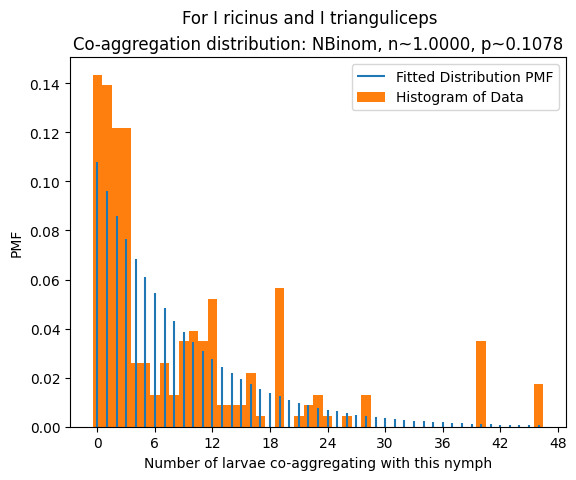

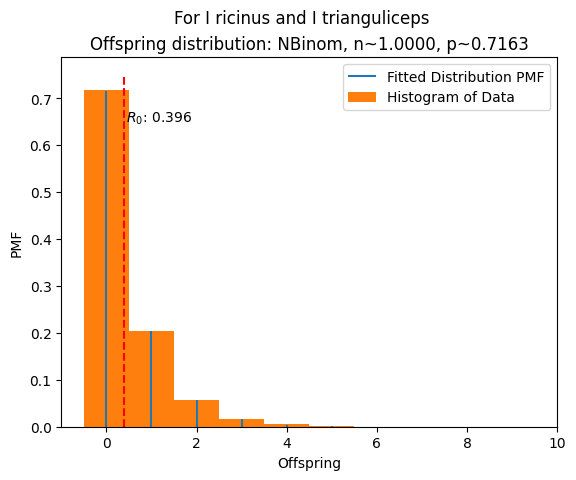

CAPTION: the co-aggregation data fitted with the Negative Binomial distribution, with the Method of Moments, and MLE.


In [6]:
coaggregation_distribution_fitted.plot()

plt.suptitle("For I ricinus and I trianguliceps")
plt.title("Co-aggregation distribution: NBinom, n~{0:.4f}, p~{1:.4f}".format(coaggregation_distribution_fitted.params.n,
                                                                    coaggregation_distribution_fitted.params.p))
plt.xlabel("Number of larvae co-aggregating with this nymph")
plt.show()

offspring_distribution_fitted.plot()
plt.suptitle("For I ricinus and I trianguliceps")
plt.title("Offspring distribution: NBinom, n~{0:.4f}, p~{1:.4f}".format(offspring_distribution_fitted.params.n,
                                                                        offspring_distribution_fitted.params.p))
plt.annotate("$R_0$: {0:.3f}".format(np.mean(offspring_distribution)), (np.mean(offspring_distribution)+0.05,0.65))
plt.vlines(x=np.mean(offspring_distribution), ymin=0, ymax=0.75, colors='r', linestyles="--")
plt.xlabel("Offspring")
plt.show()
print("CAPTION: the co-aggregation data fitted with the Negative Binomial distribution, with the Method of Moments, and MLE.")

### For the species I ricinus

In [7]:
coaggregation_distribution = np.array([], dtype=np.int64)

for i, row in df_SA_ricinus_trianguliceps.iterrows():
    nymph_count = row["ricinusN"]
    larvae_count = row["ricinusL"]
    larvae_coaggregating = np.repeat(larvae_count, nymph_count)
    coaggregation_distribution = np.append(coaggregation_distribution, larvae_coaggregating)

n_MOM, p_MOM = MOM(coaggregation_distribution)
print("METHOD OF MOMENTS n={0:.04f}, p={1:.04f}".format(n_MOM, p_MOM))
coaggregation_distribution_fitted = MLE(coaggregation_distribution, n_MOM, p_MOM, stats.nbinom)
print("MAXIMUM LIKELIHOOD ESTIMATION n={0:.04f}, p={1:.04f}".format(coaggregation_distribution_fitted.params.n, 
                                                                    coaggregation_distribution_fitted.params.p))

METHOD OF MOMENTS n=0.6549, p=0.1429
MAXIMUM LIKELIHOOD ESTIMATION n=1.0000, p=0.2029


In [8]:
sigma = 0.1 # Randolph, 1998 says 10% of larvae survive to become nymphs
c = 0.5 # Since ticks go for ears, and there are usually two ears. Sometimes a vertebrate is missing one or part of an ear, but that could be either ear
v = 0.95 # aribtrarily set to be not quite perfect
alpha = sigma*c*v
print("alpha = {0:.04f}".format(alpha))

offspring_distribution = np.array([], dtype=np.int64)
random_larvae_counts = stats.nbinom.rvs(n=coaggregation_distribution_fitted.params.n,
                                        p=coaggregation_distribution_fitted.params.p,
                                        size=100000)
for larvae_count in random_larvae_counts:
    offspring_for_multiple_nymphs = number_of_offspring_one_nymph(c, v, sigma, larvae_count)
    offspring_distribution = np.append(offspring_distribution, offspring_for_multiple_nymphs)

n_MOM, p_MOM = MOM(offspring_distribution)
print("METHOD OF MOMENTS n={0:.04f}, p={1:.04f}".format(n_MOM, p_MOM))
offspring_distribution_fitted = MLE(offspring_distribution, n_MOM, p_MOM, stats.nbinom)
print("MAXIMUM LIKELIHOOD ESTIMATION n={0:.04f}, p={1:.04f}".format(offspring_distribution_fitted.params.n, 
                                                                    offspring_distribution_fitted.params.p))

alpha = 0.0475
METHOD OF MOMENTS n=0.9968, p=0.8452
MAXIMUM LIKELIHOOD ESTIMATION n=1.0000, p=0.8462


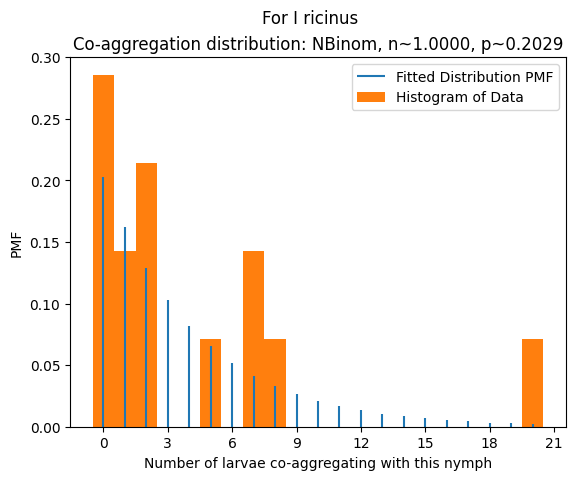

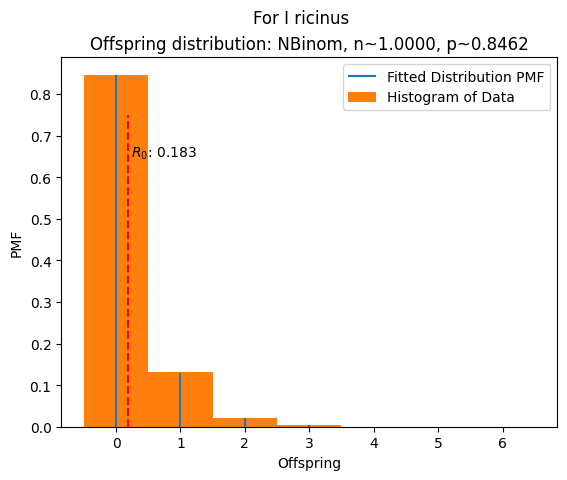

CAPTION: the co-aggregation data fitted with the Negative Binomial distribution, with the Method of Moments, and MLE.


In [9]:
coaggregation_distribution_fitted.plot()

plt.suptitle("For I ricinus")
plt.title("Co-aggregation distribution: NBinom, n~{0:.4f}, p~{1:.4f}".format(coaggregation_distribution_fitted.params.n,
                                                                    coaggregation_distribution_fitted.params.p))
plt.xlabel("Number of larvae co-aggregating with this nymph")
plt.show()

offspring_distribution_fitted.plot()
plt.suptitle("For I ricinus")
plt.title("Offspring distribution: NBinom, n~{0:.4f}, p~{1:.4f}".format(offspring_distribution_fitted.params.n,
                                                                        offspring_distribution_fitted.params.p))
plt.annotate("$R_0$: {0:.3f}".format(np.mean(offspring_distribution)), (np.mean(offspring_distribution)+0.05,0.65))
plt.vlines(x=np.mean(offspring_distribution), ymin=0, ymax=0.75, colors='r', linestyles="--")
plt.xlabel("Offspring")
plt.show()
print("CAPTION: the co-aggregation data fitted with the Negative Binomial distribution, with the Method of Moments, and MLE.")

### For the species I trianguliceps

In [10]:
coaggregation_distribution = np.array([], dtype=np.int64)

for i, row in df_SA_ricinus_trianguliceps.iterrows():
    nymph_count = row["triangulicepsN"]
    larvae_count = row["triangulicepsL"]
    larvae_coaggregating = np.repeat(larvae_count, nymph_count)
    coaggregation_distribution = np.append(coaggregation_distribution, larvae_coaggregating)

n_MOM, p_MOM = MOM(coaggregation_distribution)
print("METHOD OF MOMENTS n={0:.04f}, p={1:.04f}".format(n_MOM, p_MOM))
coaggregation_distribution_fitted = MLE(coaggregation_distribution, n_MOM, p_MOM, stats.nbinom)
print("MAXIMUM LIKELIHOOD ESTIMATION n={0:.04f}, p={1:.04f}".format(coaggregation_distribution_fitted.params.n, 
                                                                    coaggregation_distribution_fitted.params.p))

METHOD OF MOMENTS n=0.4776, p=0.0760
MAXIMUM LIKELIHOOD ESTIMATION n=1.0000, p=0.1469


In [11]:
sigma = 0.1 # Randolph, 1998 says 10% of larvae survive to become nymphs
c = 0.5 # Since ticks go for ears, and there are usually two ears. Sometimes a vertebrate is missing one or part of an ear, but that could be either ear
v = 0.95 # aribtrarily set to be not quite perfect
alpha = sigma*c*v
print("alpha = {0:.04f}".format(alpha))

offspring_distribution = np.array([], dtype=np.int64)
random_larvae_counts = stats.nbinom.rvs(n=coaggregation_distribution_fitted.params.n,
                                        p=coaggregation_distribution_fitted.params.p,
                                        size=100000)
for larvae_count in random_larvae_counts:
    offspring_for_multiple_nymphs = number_of_offspring_one_nymph(c, v, sigma, larvae_count)
    offspring_distribution = np.append(offspring_distribution, offspring_for_multiple_nymphs)

n_MOM, p_MOM = MOM(offspring_distribution)
print("METHOD OF MOMENTS n={0:.04f}, p={1:.04f}".format(n_MOM, p_MOM))
offspring_distribution_fitted = MLE(offspring_distribution, n_MOM, p_MOM, stats.nbinom)
print("MAXIMUM LIKELIHOOD ESTIMATION n={0:.04f}, p={1:.04f}".format(offspring_distribution_fitted.params.n, 
                                                                    offspring_distribution_fitted.params.p))

alpha = 0.0475
METHOD OF MOMENTS n=1.0455, p=0.7913
MAXIMUM LIKELIHOOD ESTIMATION n=1.0000, p=0.7842


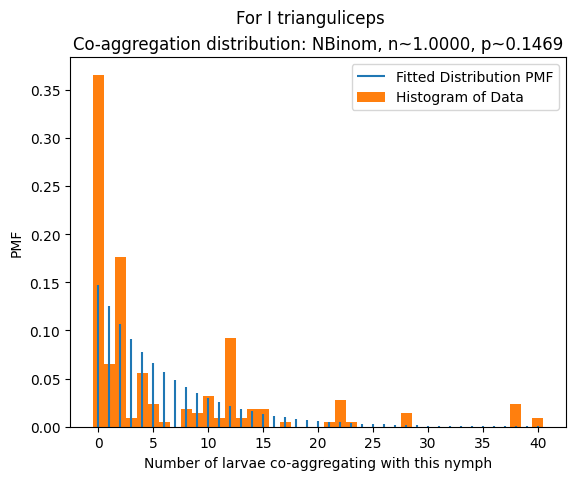

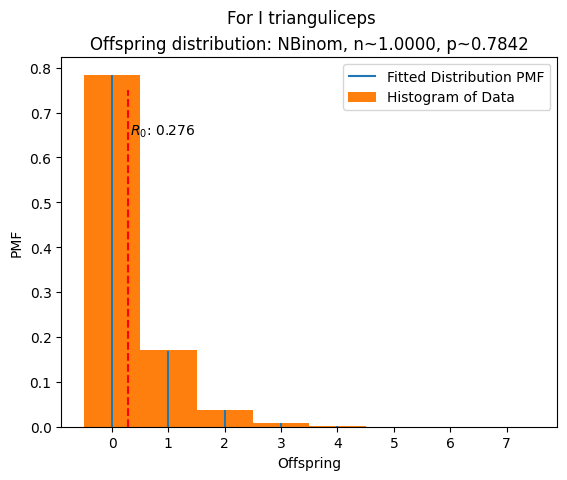

CAPTION: the co-aggregation data fitted with the Negative Binomial distribution, with the Method of Moments, and MLE.


In [12]:
coaggregation_distribution_fitted.plot()

plt.suptitle("For I trianguliceps")
plt.title("Co-aggregation distribution: NBinom, n~{0:.4f}, p~{1:.4f}".format(coaggregation_distribution_fitted.params.n,
                                                                    coaggregation_distribution_fitted.params.p))
plt.xlabel("Number of larvae co-aggregating with this nymph")
plt.show()

offspring_distribution_fitted.plot()
plt.suptitle("For I trianguliceps")
plt.title("Offspring distribution: NBinom, n~{0:.4f}, p~{1:.4f}".format(offspring_distribution_fitted.params.n,
                                                                        offspring_distribution_fitted.params.p))
plt.annotate("$R_0$: {0:.3f}".format(np.mean(offspring_distribution)), (np.mean(offspring_distribution)+0.05,0.65))
plt.vlines(x=np.mean(offspring_distribution), ymin=0, ymax=0.75, colors='r', linestyles="--")
plt.xlabel("Offspring")
plt.show()
print("CAPTION: the co-aggregation data fitted with the Negative Binomial distribution, with the Method of Moments, and MLE.")